<a href="https://colab.research.google.com/github/eviediaz/GAN_Experiment/blob/main/DiazQuevedoEvieNataly_DeepLearning_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



* GAN: Generación de imágenes
* Definir problema: qué vas a resolver y qué medirás.
* Dataset: fuente, clases, tamaño y particiones (train/val/test). La partición puede
variar según la ruta elegida.
* Comparacion de modelos (3 configuraciones del mismo modelo y su impacto o 3 GANs ligeras: DCGAN, LSGAN, WGAN)
* Métricas: ver sección “Métricas”. Presenta tablas y gráficos.
* Resultados y conclusiones: cuál fue el mejor modelo y por qué. Incluye
limitaciones y un punto breve sobre ética (datos, sesgos, uso responsable).
* Entregables: ver sección “Entregables”, página 3.



Métricas (elegir min 3)
GANs
• FID (calidad/diversidad vs. datos reales)
• KID (alternativa a FID para sets pequeños)
• Inception Score (IS)
• Pérdida del generador (curva)
• Pérdida del discriminador (curva)

#Setup

In [1]:
!pip install torch torchvision torchaudio
!pip install matplotlib numpy tqdm

In [2]:
!pip install pytorch-fid

In [15]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 60.5 MB/s eta 0:00:00


In [18]:
!pip install torch-fidelity

In [2]:
!pip install torchmetrics[image]

In [4]:
# Torch y utilidades
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance
from torchmetrics.image.inception import InceptionScore

# Numpy y visualización
import numpy as np
import matplotlib.pyplot as plt

# Barra de progreso
from tqdm import tqdm

In [5]:
# Verifica GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Usando dispositivo: {device}")

✅ Usando dispositivo: cuda


#Datos

In [6]:
# Ruta donde se almacenarán los datos
data_root = "data"

# Carga train/test sin transformaciones
train_data = datasets.FashionMNIST(root=data_root, train=True, download=True)
test_data  = datasets.FashionMNIST(root=data_root, train=False, download=True)

print(f"Imágenes de entrenamiento: {len(train_data)}")
print(f"Imágenes de prueba: {len(test_data)}")

Imágenes de entrenamiento: 60000
Imágenes de prueba: 10000


#Preprocesamiento

In [7]:
# Transformaciones: escala a [-1, 1] para usar Tanh en el generador
transform = transforms.Compose([
    transforms.Resize(32),               # opcional, para DCGAN
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # rango [-1,1]
])

# Aplicar al dataset de entrenamiento
dataset = datasets.FashionMNIST(root="data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

print(f"Total imágenes después del preprocesamiento: {len(dataset)}")

Total imágenes después del preprocesamiento: 60000


In [8]:
# Transformaciones
transform = transforms.Compose([
    transforms.Resize(32),              # Escalar a 32x32 para mejor estabilidad (opcional)
    transforms.ToTensor(),              # Convertir a tensor [0,1]
    transforms.Normalize((0.5,), (0.5,)) # Normalizar a [-1,1]
])

In [9]:
# Dataset Fashion-MNIST
dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    transform=transform,
    download=True
)

# DataLoader
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Total imágenes: {len(dataset)}")

Total imágenes: 60000


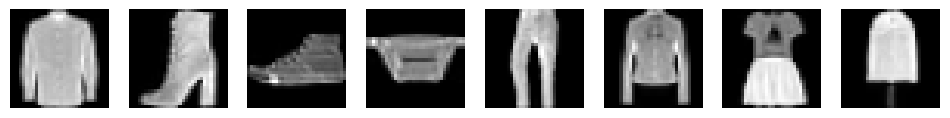

In [10]:
# Obtener un batch
images, labels = next(iter(dataloader))

# Denormalizar para visualización (volver a [0,1])
def denormalize(img):
    return img * 0.5 + 0.5

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axes[i].imshow(denormalize(images[i]).squeeze().numpy(), cmap="gray")
    axes[i].axis("off")
plt.show()

#Entrenamiento

In [11]:
# Definir el Generador
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1, features_g=64):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # input Z latent vector
            nn.ConvTranspose2d(z_dim, features_g*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_g*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g*4, features_g*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g*2, features_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)


# Definir el Discriminador
class Discriminator(nn.Module):
    def __init__(self, img_channels=1, features_d=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(img_channels, features_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d, features_d*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d*2, features_d*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)


# Función de entrenamiento
def train_dcgan(config, dataloader, device):
    z_dim = config["z_dim"]
    lr = config["lr"]
    batch_size = config["batch_size"]
    epochs = config["epochs"]

    # Modelos
    gen = Generator(z_dim=z_dim).to(device)
    disc = Discriminator().to(device)

    # Loss y optimizadores
    criterion = nn.BCELoss()
    optimizer_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

    fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

    for epoch in range(epochs):
        for real, _ in dataloader:
            real = real.to(device)
            batch_size = real.size(0)

            # Etiquetas
            label_real = torch.ones(batch_size, 1, device=device)
            label_fake = torch.zeros(batch_size, 1, device=device)

            # Entrenar Discriminador
            noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
            fake = gen(noise)

            disc_real = disc(real).view(-1, 1)
            lossD_real = criterion(disc_real, label_real)

            disc_fake = disc(fake.detach()).view(-1, 1)
            lossD_fake = criterion(disc_fake, label_fake)

            lossD = (lossD_real + lossD_fake) / 2
            optimizer_disc.zero_grad()
            lossD.backward()
            optimizer_disc.step()

            # Entrenar Generador
            output = disc(fake).view(-1, 1)
            lossG = criterion(output, label_real)  # queremos engañar al discriminador
            optimizer_gen.zero_grad()
            lossG.backward()
            optimizer_gen.step()

        print(f"Epoch [{epoch+1}/{epochs}]  Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}")

    return gen, disc, fixed_noise

In [ ]:
configs = {
    "A": {"z_dim": 100, "batch_size": 128, "lr": 0.0002, "epochs": 30},
    "B": {"z_dim": 50,  "batch_size": 64,  "lr": 0.0002, "epochs": 30},
    "C": {"z_dim": 200, "batch_size": 128, "lr": 0.0002, "epochs": 30}
}

models = {}
for name, cfg in configs.items():
    print(f"\nEntrenando configuración {name}...")
    gen, disc, fixed_noise = train_dcgan(cfg, dataloader, device)
    models[name] = (gen, disc, fixed_noise)

In [50]:
for name, (gen, disc, fixed_noise) in models.items():
    torch.save(gen.state_dict(), f"gen_{name}.pth")
    torch.save(disc.state_dict(), f"disc_{name}.pth")
    torch.save(fixed_noise, f"noise_{name}.pth")

In [46]:
configs = {
    "A": {"z_dim": 100, "batch_size": 128, "lr": 0.0002, "epochs": 30},
    "B": {"z_dim": 50,  "batch_size": 64,  "lr": 0.0002, "epochs": 30},
    "C": {"z_dim": 200, "batch_size": 128, "lr": 0.0002, "epochs": 30}
}

In [17]:
# Recrear modelos y cargar pesos entrenados
loaded_models = {}
for name, cfg in configs.items():
    # Instanciar modelos
    gen = Generator(z_dim=cfg["z_dim"]).to(device)
    disc = Discriminator().to(device)

    # Cargar pesos
    gen.load_state_dict(torch.load(f"modelos/gen_{name}.pth", map_location=device))
    disc.load_state_dict(torch.load(f"modelos/disc_{name}.pth", map_location=device))

    # Cargar ruido fijo
    fixed_noise = torch.load(f"modelos/noise_{name}.pth", map_location=device)

    # Modo evaluación
    gen.eval()
    disc.eval()

    loaded_models[name] = (gen, disc, fixed_noise)

print("✅ Modelos A/B/C cargados correctamente")

✅ Modelos A/B/C cargados correctamente


#Evaluación

In [21]:
def generate_images(gen, z_dim, device, folder="results_eval", n_images=5000, batch_size=128):
    os.makedirs(folder, exist_ok=True)
    gen.eval()
    with torch.no_grad():
        for i in range(n_images // batch_size):
            noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
            fake = gen(noise).detach().cpu()
            for j in range(fake.size(0)):
                save_image(fake[j], f"{folder}/img_{i*batch_size+j}.png", normalize=True)

In [24]:
def preprocess_for_metrics(batch):
    """
    Convierte tensores float [-1, 1] o [0, 1] en uint8 [0, 255]
    para métricas como FID / IS.
    """
    if batch.dtype != torch.uint8:
        # Si estaba en [-1, 1] → lo llevamos a [0, 1]
        if batch.min() < 0:
            batch = (batch + 1) / 2
        # Escalamos a [0, 255] y convertimos a uint8
        batch = (batch * 255).clamp(0, 255).byte()
    return batch

In [28]:
def to_rgb(x):
    # x: [B, 1, H, W]
    return x.repeat(1, 3, 1, 1)  # [B, 3, H, W]

In [48]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance
from torchmetrics.image.inception import InceptionScore

# Evaluación por cada modelo
results = {}
fid_scores = []
kid_scores = []
is_means = []
is_stds = []

for name, (gen, disc, fixed_noise) in loaded_models.items():
    print(f"🔎 Evaluando modelo {name}...")

    z_dim = configs[name]["z_dim"]
    batch_size = configs[name]["batch_size"]

    # Inicializar métricas
    fid = FrechetInceptionDistance(feature=64).to(device)
    kid = KernelInceptionDistance(subset_size=50).to(device)
    inception = InceptionScore().to(device)

    # Evaluar sobre un número limitado de batches
    num_batches_eval = 5  # <-- puedes ajustar este número
    for i, (real_batch, _) in enumerate(dataloader):
        if i >= num_batches_eval:
            break

        real_batch = real_batch.to(device)

        # Generar imágenes falsas
        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_batch = gen(noise)

        # Preprocesar imágenes
        real_batch_proc = preprocess_for_metrics(real_batch)
        fake_batch_proc = preprocess_for_metrics(fake_batch)

        real_batch_proc = (real_batch * 255).byte()
        fake_batch_proc = (fake_batch * 255).byte()

        # Convertir a RGB
        real_batch_proc = to_rgb(real_batch_proc)
        fake_batch_proc = to_rgb(fake_batch_proc)

        fid.update(real_batch_proc, real=True)
        fid.update(fake_batch_proc, real=False)

        # Actualizar métricas
        fid.update(real_batch_proc, real=True)
        fid.update(fake_batch_proc, real=False)

        kid.update(real_batch_proc, real=True)
        kid.update(fake_batch_proc, real=False)

        inception.update(fake_batch_proc)

    # Calcular puntajes
    fid_score = fid.compute().item()
    kid_score = kid.compute()[0].item()
    inception_mean, inception_std = inception.compute()

    fid_scores.append(fid_score)
    kid_scores.append(kid_score)
    is_means.append(inception_mean.item())
    is_stds.append(inception_std.item())

    results[name] = {
        "FID": fid_score,
        "KID": kid_score,
        "IS_mean": inception_mean.item(),
        "IS_std": inception_std.item()
    }

# Mostrar resultados
for name, metrics in results.items():
    print(f"\n📊 Resultados {name}:")
    for k, v in metrics.items():
        print(f"  {k}: {v:.4f}")

🔎 Evaluando modelo A...


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


🔎 Evaluando modelo B...
🔎 Evaluando modelo C...

📊 Resultados A:
  FID: 0.1147
  KID: 0.0346
  IS_mean: 3.9209
  IS_std: 0.3528

📊 Resultados B:
  FID: 0.1058
  KID: 0.0351
  IS_mean: 3.4421
  IS_std: 0.5625

📊 Resultados C:
  FID: 0.1425
  KID: 0.0423
  IS_mean: 3.4936
  IS_std: 0.2118


In [32]:
import matplotlib.pyplot as plt

def plot_losses(losses_G, losses_D, title="Loss Curves"):
    plt.figure(figsize=(8,4))
    plt.plot(losses_G, label="Generador")
    plt.plot(losses_D, label="Discriminador")
    plt.xlabel("Iteraciones")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

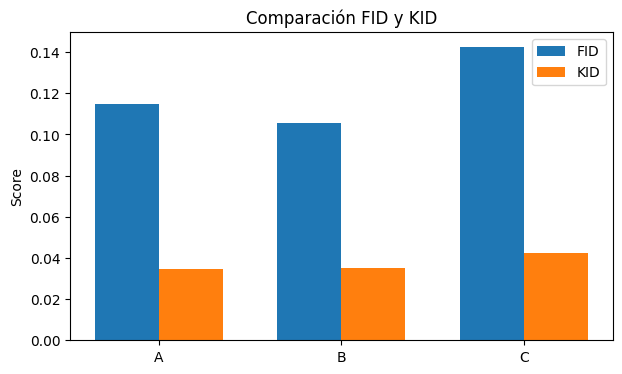

In [50]:
# Datos
x = np.arange(len(configs))
width = 0.35

plt.figure(figsize=(7,4))
plt.bar(x, fid_scores, width, label="FID")
plt.bar(x + width, kid_scores, width, label="KID")
plt.xticks(x + width/2, configs)
plt.ylabel("Score")
plt.title("Comparación FID y KID")
plt.legend()
plt.show()

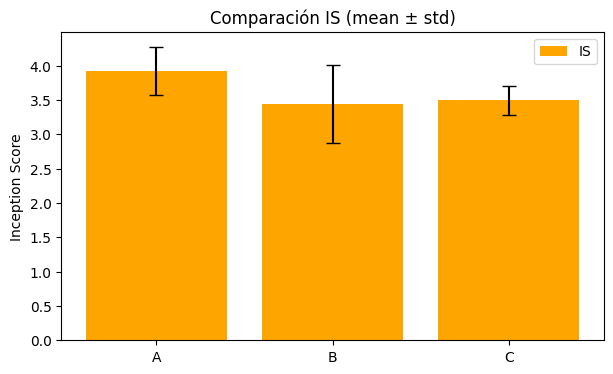

In [59]:
plt.figure(figsize=(7,4))
plt.bar(x, is_means, yerr=is_stds, capsize=5, label="IS", color="orange")
plt.ylabel("Inception Score")
plt.title("Comparación IS (mean ± std)")
plt.xticks(x, configs)
plt.legend()
plt.show()

In [61]:
import pandas as pd

df_results = pd.DataFrame({
    "Config": x,
    "FID": fid_scores,
    "KID": kid_scores,
    "IS_mean": is_means,
    "IS_std": is_stds
})

print(df_results)

   Config       FID       KID   IS_mean    IS_std
0       0  0.114672  0.034583  3.920857  0.352788
1       1  0.105787  0.035137  3.442106  0.562540
2       2  0.142536  0.042281  3.493572  0.211843


#Inferencia de ejemplo

#Guardado de resultados